## Investigate Anomaly Detection Results



Check the parameters and search space for trends in anomaly detection.

The search space for the input parameters we're looking at yields an intractable computation.

The question being asked of the data is, *"what training period yields the greatest number of anomalies detected in summer-fall?"*.

Limiting the problem somewhat, the training period is set to to any combination of months in a single year.  The search space for this scenario is roughly 50K permutations.  The cost of search for a random subselection is roughly 1s per subset.  In other words, to run the anomaly detection algorithm (using the tensorflow backend which is already computationally optimized) on a random sample of 60 out of 50K options takes one minute. 141 stations takes over two hours.  While there may be room to optimize the code surrounding the central AD function, this segment of the research question focuses instead on optimization of the search itself, with the random search used as a benchmark.  At this point it should be stated that if all of the weather radar data were available, the anomaly detection step could be entirely avoided, to the benefit of the primary research question comparing radar precipitation and measured runoff.  However, the data are not available as such, and retrieving weather radar images is sufficiently costly to justify an event-based approach rather than seasons or years.

   

An efficient AD method should maximize the information gathered over a given number of weather radar data calls, commensurate with the number of viable rainfall-runoff events.  

The AD algorithm takes as input a matrix of streamflow observations, where each row represents an observation, and each column represents a marginal lag of the original daily flow series.  Principal Component Analysis is run on the normalized input dataset, and the number of components carried is determined by the number required to explain 90% of the variance.  In general, the number of components required to meet the 90% threshold is between 1 and 3.

The effectiveness of training data could simply be measured by the number of events detected, however several factors confound such metrics, namely the sheer number of events is too large for verification.  An information theoretic approach would measure the information content of the array of pixel values representing the catchment basin.  Consider the following bounding cases:  a sequence of radar images where no rainfall was detected by radar should yield a sequence of constant matrices of rgb values.  Such a scenario corresponds to low variance (low information).  On the other hand, a sequence of radar images capturing continuous dynamics of precipitation events would yield a sequence of matrices of rgb values with high variance (high information).  The efficacy of the training data selection algorithm may be better quantified by the variance in the data captured.  Since each basin has a unique shape, basins cannot be directly compared (in the same way the faces exercise was undertaken).  Instead, some unit measure could be used to compare information across watersheds, such as variance per pixel, though this may serve to add bias by encompassing the drainage area into the metric.


In [1]:
import os
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

import colorcet as cc
from numpy import linspace
from scipy.stats.kde import gaussian_kde

from bokeh.io import output_file, show, output_notebook
from bokeh.models import ColumnDataSource, FixedTicker, PrintfTickFormatter
from bokeh.plotting import figure
from bokeh.sampledata.perceptions import probly
output_notebook()

Loading BokehJS ...

In [2]:
BASE_DIR = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(''))))
DB_DIR = os.path.join(BASE_DIR, 'code/hydat_db')
PROJECT_DIR = os.path.abspath('')
RESULTS_DIR = os.path.join(PROJECT_DIR, 'data/AD_results')

In [3]:
results_folders = os.listdir(RESULTS_DIR)

In [4]:
results_dict = {}
for folder in results_folders:
    folder_path = os.path.join(RESULTS_DIR, folder)
    n_samples = folder_path.split('_')[1].split('.')[0]
    all_sites = [e.split('_')[0] for e in os.listdir(folder_path)]
    results_dict[folder] = {site: pd.read_csv(os.path.join(folder_path, site + '_results.csv')) for site in all_sites}
    


In [7]:
test_folder = 'sample_30'

In [8]:
results_df5 = results_dict[test_folder]

df = pd.concat([results_df5[d] for d in results_df5])

months = []
len_results = []

months_dict = {m: [] for m in range(1,13,1)}

for idx, row in df.iterrows():
    months = [int(e) for e in row['train_months'].strip('(').strip(')').strip(' ').split(',') if e != '']
    
    for m in months:
        score = row['len_results']
        months_dict[m].append(score)
        
years = []
len_results = []
years_dict = {y: [] for y in range(2007, 2019, 1)}

max_score = 0

for idx, row in df.iterrows():
    year = row['train_year']
    
    score = row['len_results']
    
    years_dict[year].append(score)
    
    if score > max_score:
        max_score = score
       

In [38]:

def ridge(category, data, scale=20):
    return list(zip([category]*len(data), scale*data))

# cats = list(reversed(probly.keys()))
cats = [e for e in list(years_dict.keys())]

palette = [cc.rainbow[i*15] for i in range(17)]

source = ColumnDataSource(data=dict())

# p = figure(y_range=cats, plot_width=800, x_range=(-10, 100), toolbar_location=None)
p = figure(plot_width=800, plot_height=400, toolbar_location=None)
all_cats_data = []
for i, cat in enumerate(cats):
    data = years_dict[cat]
    all_cats_data += data
    df = pd.DataFrame()
    min_data, max_data = min(data), max(data)
    df['x'] = np.linspace(min_data, max_data, int((max_data - min_data) / 0.1))
    pdf = gaussian_kde(data)
#     df = construct_df(data)
    df['{}_pdf'.format(cat)] = pdf(df['x'])    
    p.line(df['x'], df['{}_pdf'.format(cat)], line_color=palette[i], legend_label=str(cat))

all_df = pd.DataFrame()
min_data, max_data = min(all_cats_data), max(all_cats_data)
all_df['x'] = np.linspace(min_data, max_data, len(all_cats_data))
all_pdf = gaussian_kde(all_cats_data)

all_df['all_pdf'] = all_pdf(all_df['x']) 
p.line(all_df['x'], all_df['all_pdf'], line_color='black', legend_label='All Data', 
       line_dash='dashed', line_width=2)

p.outline_line_color = None
p.background_fill_color = "#efefef"

# p.xaxis.ticker = FixedTicker(ticks=list(range(0, 101, 10)))
# p.xaxis.formatter = PrintfTickFormatter(format="%d%%")
p.xaxis.axis_label = 'Number of Events Detected'
p.yaxis.axis_label = 'P(X)'

p.ygrid.grid_line_color = None
p.xgrid.grid_line_color = "#dddddd"
# p.xgrid.ticker = p.xaxis.ticker

p.axis.minor_tick_line_color = None
p.axis.major_tick_line_color = None
p.axis.axis_line_color = None

p.y_range.range_padding = 0.12

show(p)

[2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]


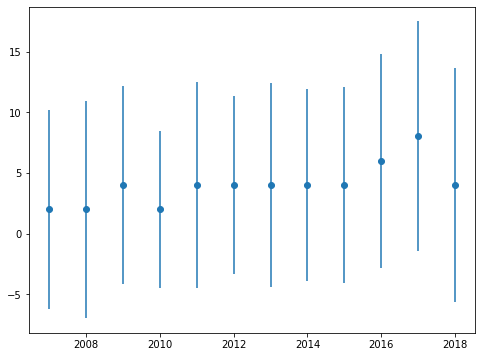

In [18]:
x = [y for y in years_dict]
y = [np.median(years_dict[a]) for a in years_dict]
y_err = [np.std(years_dict[a]) for a in years_dict]
fig, ax = plt.subplots(figsize=(8,6))
plt.errorbar(x, y, yerr=y_err, fmt='o')
print(x)


In [ ]:
# for each station, find the characteristics that 
# yield the highest return
test_folder = 'sample_50'

results_df5 = results_dict[test_folder]

df = pd.concat([results_df5[d] for d in results_df5])

months = []
len_results = []

months_dict = {m: [] for m in range(1,13,1)}

for idx, row in df.iterrows():
    months = [int(e) for e in row['train_months'].strip('(').strip(')').strip(' ').split(',') if e != '']
    

## Do PCA on the series of variables to see what explains the variability in the data.

Also, in the results dataframe, the radar station is showing the wsc station in error.

Fix in the Find_Events.py script.

In [ ]:
def do_PCA(X_train, X_test):
    
    for n_components in range(2, 6):

        pca = PCA(n_components=n_components, svd_solver= 'full')
        X_train_PCA = pca.fit_transform(X_train)
        X_train_PCA = pd.DataFrame(X_train_PCA)
        X_train_PCA.index = X_train.index

        X_test_PCA = pca.transform(X_test)
        X_test_PCA = pd.DataFrame(X_test_PCA)
        X_test_PCA.index = X_test.index

        var_expl = 100*np.sum(pca.explained_variance_ratio_)
        if var_expl >= 90:
            return X_train_PCA, X_test_PCA, var_expl, n_components
    return X_train_PCA, X_test_PCA, var_expl, n_components